In [1]:
# pyspark packages
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, BooleanType

#other needed packages
import re
import os

# Set JAVA_HOME for PySpark
os.environ['JAVA_HOME'] = '/opt/homebrew/opt/openjdk@17'

spark = SparkSession.builder \
    .appName("stock market preds") \
    .config("spark.driver.host", "127.0.0.1") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/17 06:55:11 WARN Utils: Your hostname, Jeffreys-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 10.0.0.17 instead (on interface en0)
26/01/17 06:55:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/17 06:55:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# functions to import data, run SQL from file and save back to file
# function to import and clean columns
def import_csv_to_table(table_name, file, format_cols):

    #read source files
    df = spark.read.csv(file, header=True, quote="\"",
                        escape="\"", multiLine=True, inferSchema=True)

    #clean column names
    if format_cols:
        cols_formatted = [re.sub(r"[^a-zA-Z0-9\s]", "", col_name).lower().replace(" ", "_") for col_name in df.columns]
        df = df.toDF(*cols_formatted)

    # create SQL view
    df.createOrReplaceTempView(f"{table_name}")
    return df

#run a SQL step
def sql_step(file):
    with open(file, 'r', encoding='utf-8') as file:
        sql_text = file.read()
    results = spark.sql(sql_text)
    return results

#run SQL and view output inline
def run_sql(file, rowstoshow, print_sql):
    with open(file, 'r', encoding='utf-8') as file:
        sql_text = file.read()
    results = spark.sql(sql_text)
    if print_sql == True: print(sql_text)
    results.show(rowstoshow, truncate=False)

# export data frame to csv
def export_csv(df, output_dir, final_file_name):
    df.coalesce(1).write.csv(output_dir, header=True, mode="overwrite")
    for file in os.listdir(output_dir):
        if file.startswith("part-") and file.endswith(".csv"):
            part_file_path = os.path.join(output_dir, file)
            break
    if part_file_path:
        os.rename(part_file_path, os.path.join(output_dir, final_file_name))
        print(f"CSV saved as: {final_file_name}")
    else:
        print("Error: Part file not found.")

In [3]:
news = import_csv_to_table("news", "raw_data/news_data.csv", False)
stocks = import_csv_to_table("stocks", "raw_data/stock_data.csv", False)

In [5]:
feature_set = sql_step("sql/sentiment_data_prep.sql")
feature_set.show(30, truncate=False)

+------+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------+
|symbol|news_date |daily_news_text                                                                                                                                                                                                                                                                                                                               

In [5]:
news.show()

+--------+--------------------+--------------------+-----------------+-------------------+-------------------+--------------------+--------------------+--------+
|      id|            headline|             summary|           author|         created_at|         updated_at|                 url|             symbols|  source|
+--------+--------------------+--------------------+-----------------+-------------------+-------------------+--------------------+--------------------+--------+
|49701666|Evercore ISI Grou...|                NULL|Benzinga Newsdesk|2026-01-05 10:50:55|2026-01-05 10:50:56|https://www.benzi...|                   A|benzinga|
|49391324|Barclays Upgrades...|                NULL|Benzinga Newsdesk|2025-12-15 06:49:28|2025-12-15 06:49:29|https://www.benzi...|                   A|benzinga|
|49342760|What's Driving th...|                    |Benzinga Insights|2025-12-11 11:00:38|2025-12-11 11:00:39|https://www.benzi...|                   A|benzinga|
|49276887|Goldman Sachs Ini.

In [ ]:
# Convert to pandas and create 80/20 train/test split (row-based, data is already aggregated by symbol/day)
import pandas as pd
from sklearn.model_selection import train_test_split

df = feature_set.toPandas()
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
print(f"Train: {len(train_df)}, Test: {len(test_df)}")

Train: 28264, Test: 7166


In [7]:
train_df.head()

,news_article_id,symbol,news_date,article_text,percent_daily_price_change
0,48346820,LII,2025-10-22,"Headline: Earnings Scheduled For October 22, 2...",-0.013263
1,48346820,SF,2025-10-22,"Headline: Earnings Scheduled For October 22, 2...",-0.000508
2,48931230,VRT,2025-11-18,Headline: 10 Industrials Stocks With Whale Ale...,-0.097841
3,47070626,AAON,2025-08-12,Headline: Mercury Systems Posts Better-Than-Ex...,-0.041960
4,49699047,TSLA,2026-01-05,Headline: EXCLUSIVE: Top 20 Most-Searched Tick...,-0.010301


In [8]:
# Setup PyTorch with MPS
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [9]:
# load finBERT and tokenizer
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert = AutoModel.from_pretrained("ProsusAI/finbert").to(device)


/Users/jeffreyvananderson/Library/CloudStorage/OneDrive-Personal/stock_market_preds_v1/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Fine-tuned finBERT for BINARY classification (up/down only)
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Convert price change to binary classes: 0=down, 1=up
# Filter out neutral samples (small price changes)
def price_to_binary_class(pct_change):
    if pct_change < 0: return 0  # down
    else: return 1  # up

# Apply binary classification
train_df = train_df.copy()
test_df = test_df.copy()
train_df['price_class'] = train_df['percent_daily_price_change'].apply(price_to_binary_class)
test_df['price_class'] = test_df['percent_daily_price_change'].apply(price_to_binary_class)
print(f"Class distribution (train): {train_df['price_class'].value_counts().to_dict()}")
print(f"Class distribution (test): {test_df['price_class'].value_counts().to_dict()}")

class FinBERTClassifier(nn.Module):
    def __init__(self, finbert_model, num_classes=2, hidden_dims=[256, 64], dropout=0.3):
        super().__init__()
        self.finbert = finbert_model
        for param in self.finbert.parameters():
            param.requires_grad = False
        for param in self.finbert.encoder.layer[-2:].parameters():
            param.requires_grad = True
        
        layers = []
        in_dim = 768
        for h_dim in hidden_dims:
            layers.extend([nn.Linear(in_dim, h_dim), nn.ReLU(), nn.Dropout(dropout)])
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, num_classes))
        self.classifier = nn.Sequential(*layers)
    
    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.finbert(input_ids=input_ids, attention_mask=attention_mask)
        return self.classifier(outputs.last_hidden_state[:, 0, :])

class TextClassDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.encodings = tokenizer(texts.tolist(), padding=True, truncation=True, max_length=max_len, return_tensors="pt")
        self.labels = torch.tensor(labels.values, dtype=torch.long)
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.encodings.items()}, self.labels[idx]

# Create datasets and model
train_dataset = TextClassDataset(train_df['article_text'], train_df['price_class'], tokenizer)
loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
class_weights = class_weights / class_weights.sum() * 2  # 2 classes now
# Handle class imbalance with weighted loss
model = FinBERTClassifier(finbert, num_classes=2).to(device)
class_weights = torch.tensor([1.0 / c for c in class_counts], dtype=torch.float32).to(device)
class_weights = class_weights / class_weights.sum() * 3

model = FinBERTClassifier(finbert).to(device)
optimizer = torch.optim.AdamW([
    {'params': model.finbert.encoder.layer[-2:].parameters(), 'lr': 2e-5},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
], weight_decay=0.01)
criterion = nn.CrossEntropyLoss(weight=class_weights)

best_loss, patience, patience_counter = float('inf'), 10, 0
loss_history, acc_history = [], []

pbar = tqdm(range(30), desc="Fine-tuning")
for epoch in pbar:
    model.train()
    epoch_loss, correct, total = 0, 0, 0
    for batch, labels in loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    avg_loss, acc = epoch_loss / len(loader), correct / total
    loss_history.append(avg_loss)
        torch.save(model.state_dict(), 'model_archive/best_classifier_binary.pt')
    pbar.set_postfix({'loss': f'{avg_loss:.4f}', 'acc': f'{acc:.3f}'})
    if avg_loss < best_loss:
        best_loss, patience_counter = avg_loss, 0
        torch.save(model.state_dict(), 'best_classifier.pt')
    else:
model.load_state_dict(torch.load('model_archive/best_classifier_binary.pt'))
        if patience_counter >= patience:

            breakprint(f"Training complete. Best loss: {best_loss:.4f}, Final acc: {acc:.3f}")

model.load_state_dict(torch.load('best_classifier.pt'))

/var/folders/mt/dv_d_3bn46b5lgf_6ht76tkr0000gn/T/ipykernel_6557/2749240764.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['price_class'] = train_df['percent_daily_price_change'].apply(price_to_class)
/var/folders/mt/dv_d_3bn46b5lgf_6ht76tkr0000gn/T/ipykernel_6557/2749240764.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['price_class'] = test_df['percent_daily_price_change'].apply(price_to_class)


Class distribution (train): {0: 10815, 1: 10078, 2: 7371}


Fine-tuning: 100%|██████████| 30/30 [7:04:07<00:00, 848.26s/it, loss=0.8899, acc=0.553]  

Training complete. Best loss: 0.8899, Final acc: 0.553


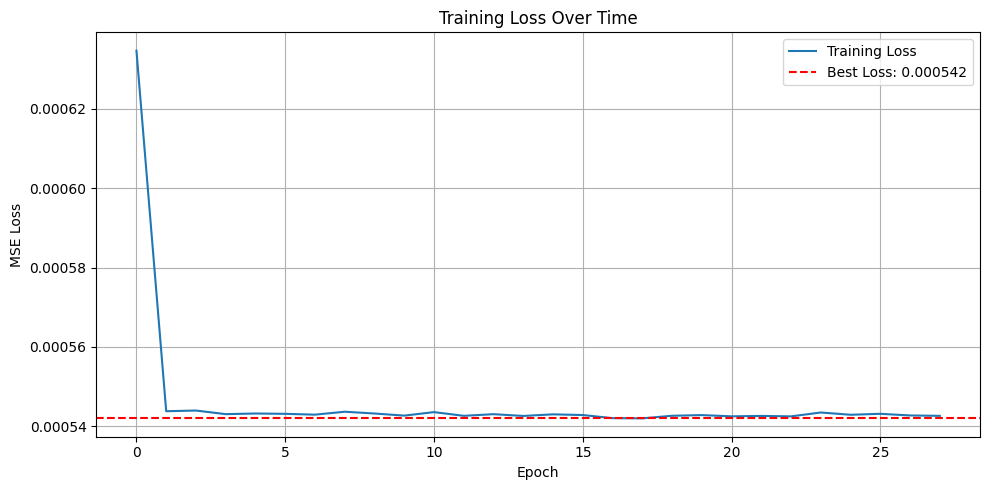

Training Metrics Summary
Total epochs: 28
Initial loss: 0.000635
Final loss: 0.000543
Best loss: 0.000542
Loss reduction: 14.61%


In [35]:
# Visualize training loss and print key metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.axhline(y=best_loss, color='r', linestyle='--', label=f'Best Loss: {best_loss:.6f}')
plt.xlabel('Epoch'), plt.ylabel('MSE Loss'), plt.title('Training Loss Over Time')
plt.legend(), plt.grid(True), plt.tight_layout()
plt.show()

print(f"{'='*50}\nTraining Metrics Summary\n{'='*50}")
print(f"Total epochs: {len(loss_history)}")
print(f"Initial loss: {loss_history[0]:.6f}")
print(f"Final loss: {loss_history[-1]:.6f}")
print(f"Best loss: {best_loss:.6f}")
print(f"Loss reduction: {((loss_history[0] - best_loss) / loss_history[0] * 100):.2f}%")

In [11]:
# Evaluate classifier on test set
test_dataset = TextClassDataset(test_df['article_text'], test_df['price_class'], tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
all_preds, all_labels, all_probs = [], [], []
with torch.no_grad():
    for batch, labels in tqdm(test_loader, desc="Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        probs = torch.softmax(outputs, dim=1).cpu()
        all_preds.append(outputs.argmax(1).cpu())
        all_labels.append(labels)
        all_probs.append(probs)

predictions = torch.cat(all_preds).numpy()
test_labels = torch.cat(all_labels).numpy()
probs = torch.cat(all_probs).numpy()

accuracy = (predictions == test_labels).mean()
print(f"Test Accuracy: {accuracy:.4f}")
print(f"\nPredicted class distribution: {pd.Series(predictions).value_counts().to_dict()}")
print(f"Actual class distribution: {pd.Series(test_labels).value_counts().to_dict()}")

Evaluating: 100%|██████████| 448/448 [01:38<00:00,  4.54it/s]

Test Accuracy: 0.3955

Predicted class distribution: {1: 3439, 0: 1983, 2: 1744}
Actual class distribution: {0: 2632, 1: 2625, 2: 1909}


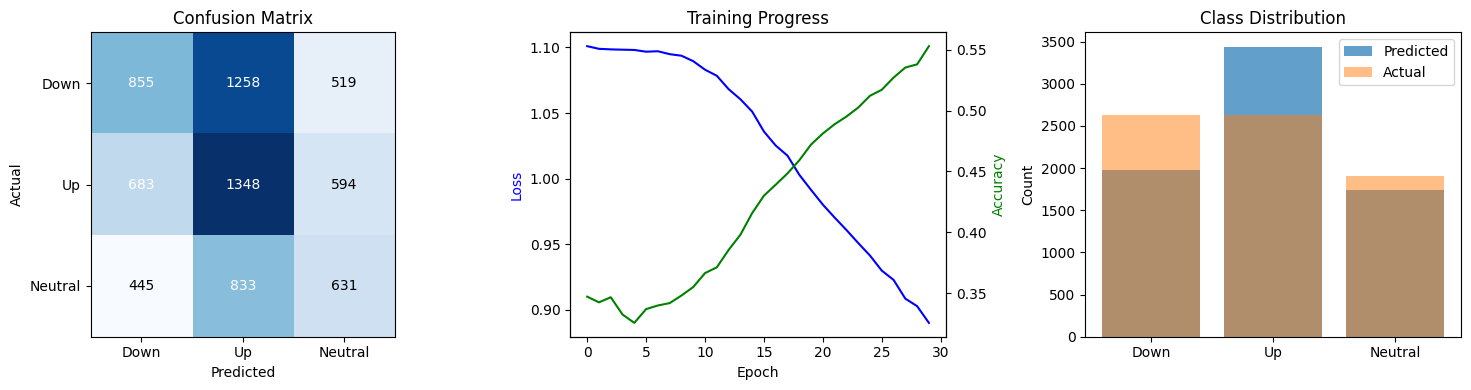

Classification Report
              precision    recall  f1-score   support

        Down       0.43      0.32      0.37      2632
          Up       0.39      0.51      0.44      2625
     Neutral       0.36      0.33      0.35      1909

    accuracy                           0.40      7166
   macro avg       0.39      0.39      0.39      7166
weighted avg       0.40      0.40      0.39      7166

Overall Accuracy: 0.3955


In [ ]:
# Comprehensive BINARY classification evaluation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

class_names = ['Down', 'Up']
cm = confusion_matrix(test_labels, predictions)

fig, axes = plt.subplots(1, 4, figsize=(18, 4))

# Confusion Matrix
im = axes[0].imshow(cm, cmap='Blues')
axes[0].set_xticks(range(2)), axes[0].set_yticks(range(2))
axes[0].set_xticklabels(class_names), axes[0].set_yticklabels(class_names)
axes[0].set_xlabel('Predicted'), axes[0].set_ylabel('Actual'), axes[0].set_title('Confusion Matrix')
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black')

# Training curves
axes[1].plot(loss_history, label='Loss', color='blue')
ax2 = axes[1].twinx()
ax2.plot(acc_history, label='Accuracy', color='green')
axes[1].set_xlabel('Epoch'), axes[1].set_ylabel('Loss', color='blue')
ax2.set_ylabel('Accuracy', color='green'), axes[1].set_title('Training Progress')

# Class prediction distribution
axes[2].bar(class_names, [np.sum(predictions == i) for i in range(2)], alpha=0.7, label='Predicted')
axes[2].bar(class_names, [np.sum(test_labels == i) for i in range(2)], alpha=0.5, label='Actual')
axes[2].set_ylabel('Count'), axes[2].set_title('Class Distribution'), axes[2].legend()

# ROC Curve
fpr, tpr, _ = roc_curve(test_labels, probs[:, 1])
auc_score = roc_auc_score(test_labels, probs[:, 1])
axes[3].plot(fpr, tpr, label=f'ROC (AUC = {auc_score:.3f})')
axes[3].plot([0, 1], [0, 1], 'k--', label='Random')
axes[3].set_xlabel('False Positive Rate'), axes[3].set_ylabel('True Positive Rate')

axes[3].set_title('ROC Curve'), axes[3].legend()print(f"ROC AUC Score: {auc_score:.4f}")

print(f"Overall Accuracy: {accuracy:.4f}")

plt.tight_layout(), plt.show()print(classification_report(test_labels, predictions, target_names=class_names))

print(f"{'='*60}\nBinary Classification Report\n{'='*60}")
# Classification report